In [165]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from itertools import groupby
import json
%matplotlib inline

In [166]:
class GetParameters:
    def __init__(self):
        self.base = 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&'
    
    def datasetList(self):
        url = self.base+'&method=GETDATASETLIST'
        req = requests.get(url)
        ret = req.json()
        dsetname = [i['DatasetName'] for i in ret['BEAAPI']['Results']['Dataset']]
        return dsetname
    
    def paramList(self, name):
        url = self.base+'&method=GETPARAMETERLIST&datasetname='+name
        req = requests.get(url)
        ret = req.json()['BEAAPI']['Results']['Parameter']
        return ret
    
class GetData(GetParameters):
    def __init__(self,dname):
        super().__init__()
        self.vals = super().paramList(dname)
        self.parname = [i['ParameterName'] for i in self.vals]
        self.dname = dname
    
    def paramVals(self):
        
        paramVal = {}
        for name in self.parname:
            url = self.base+'&method=GETPARAMETERVALUES&datasetname='+self.dname+'&parametername='+name
            req = requests.get(url)
            ret = req.json() 
            paramVal[name] = [i for i in ret['BEAAPI']['Results']['ParamValue']]
        return paramVal
        
    def cases(self):
        
        if self.dname == 'MNE':
            urlmne = self.base+'&method=GETDATA'+'&datasetname='+self.dname+'&'
            dirInv = {'OutwardCountry': {'DirectionOfInvestment':'Outward', 'Classification': 'Country', 'Year':'All'},
                       'InwardCountry': {'DirectionOfInvestment':'Inward', 'Classification': 'Country', 'Year':'All'},
                       'OutwardIndustry': {'DirectionOfInvestment':'Outward', 'Classification': 'Industry', 'Year':'All'},
                       'InwardIndustry' : {'DirectionOfInvestment':'Inward', 'Classification': 'Industry', 'Year':'All'}}
        
            urls = {}
            for x in dirInv:
                urlcomp = ""
                for key,val in dirInv[x].items():
                    urlcomp += key+'='+val+'&'
                urlcomp = urlcomp.rstrip('&')
                urls[x] = urlmne+urlcomp
            print(urls)

            amneParams = {'Parent': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'},
                     'State': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'},
                     'Outward': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'},
                     'Inward': {'DirectionOfInvestment': 'Parent', 'OwnershipLevel':'1', 'NonBankAffiliatesOnly':'0','Classification':'Industry','Year':'All'}}
        
        if self.dname == 'FixedAssets':
            tNamesFA = [i['TableName'] for i in self.paramVals()['TableName']]            
    
            urlFA = self.base+'method=GETDATA'+'&datasetname='+self.dname+'&tablename='
            urlsFA = {}

            for x in tNamesFA:
                urlsFA[x] = urlFA+x+'&year=All'
            print(urlsFA)


In [167]:
a1 = GetParameters()
dlist = a1.datasetList()

In [168]:
print(dlist)

['NIPA', 'NIUnderlyingDetail', 'MNE', 'FixedAssets', 'ITA', 'IIP', 'InputOutput', 'IntlServTrade', 'GDPbyIndustry', 'Regional', 'UnderlyingGDPbyIndustry', 'APIDatasetMetaData']


In [169]:
a2 = GetData('GDPbyIndustry')
indgdp = a2.paramVals()
indgdp

{'Frequency': [{'Key': 'A', 'Desc': 'Annual'},
  {'Key': 'Q', 'Desc': 'Quarterly'}],
 'Industry': [{'Key': '11',
   'Desc': 'Agriculture, forestry, fishing, and hunting (A,Q)'},
  {'Key': '111CA', 'Desc': 'Farms (A,Q)'},
  {'Key': '113FF', 'Desc': 'Forestry, fishing, and related activities (A,Q)'},
  {'Key': '21', 'Desc': 'Mining (A,Q)'},
  {'Key': '211', 'Desc': 'Oil and gas extraction (A,Q)'},
  {'Key': '212', 'Desc': 'Mining, except oil and gas (A,Q)'},
  {'Key': '213', 'Desc': 'Support activities for mining (A,Q)'},
  {'Key': '22', 'Desc': 'Utilities (A,Q)'},
  {'Key': '23', 'Desc': 'Construction (A,Q)'},
  {'Key': '311FT', 'Desc': 'Food and beverage and tobacco products (A,Q)'},
  {'Key': '313TT', 'Desc': 'Textile mills and textile product mills (A,Q)'},
  {'Key': '315AL', 'Desc': 'Apparel and leather and allied products (A,Q)'},
  {'Key': '31G', 'Desc': 'Manufacturing (A,Q)'},
  {'Key': '31ND', 'Desc': 'Nondurable goods (A,Q)'},
  {'Key': '321', 'Desc': 'Wood products (A,Q)'},
  

In [171]:
urlIGdp = 'http://apps.bea.gov/api/data?&UserID=F2205008-0F90-4F72-B77E-D7938D6188E6&ResultFormat=JSON&method=GetData&datasetname=GDPbyindustry&Year=ALL&Frequency=A,Q&TableID=ALL&Industry=ALL'

In [172]:
class IndustryGDP_Processing:
    def __init__(self, url):
        self.address = url
    
    def dataRetrieval(self):
        req = requests.get(self.address)
        ret = req.json()
        #data = [i for i in ret['BEAAPI']['Results']['Data']]
        return ret
    
    def parseData(self):
        data = self.dataRetrieval()
        data.sort(key=itemgetter('SeriesID','RowCode','Row','Year'))
        series25 = []
        for category, value in groupby(data, key=itemgetter('SeriesID','RowCode')):
            for i in value:
                series25.append(i)
        return series25

In [173]:
a3 = IndustryGDP_Processing(urlIGdp)

data = a3.dataRetrieval()

In [174]:
datalist = [i['Data'] for i in data['BEAAPI']['Results']]

In [200]:
datanotes = [i['Notes'] for i in data['BEAAPI']['Results']]
datanotes

[[{'NoteRef': '1.1.A,Q',
   'NoteText': '1. Consists of agriculture, forestry, fishing, and hunting; mining; construction; and manufacturing.'},
  {'NoteRef': '1.2.A,Q',
   'NoteText': '2. Consists of utilities; wholesale trade; retail trade; transportation and warehousing; information; finance, insurance, real estate, rental, and leasing; professional and business services; educational services, health care, and social assistance; arts, entertainment, recreation, accommodation, and food services; and other services, except government.'},
  {'NoteRef': '1.3.A,Q',
   'NoteText': '3. Consists of computer and electronic product manufacturing (excluding navigational, measuring, electromedical, and control instruments manufacturing); software publishers; broadcasting and telecommunications; data processing, hosting and related services; internet publishing and broadcasting and web search portals; and computer systems design and related services.'},
  {'NoteRef': '1.0.A,Q',
   'NoteText': 'N

In [175]:
df = pd.DataFrame(datalist[0])

In [255]:
print(datanotes[0][0].values())

dict_values(['1.1.A,Q', '1. Consists of agriculture, forestry, fishing, and hunting; mining; construction; and manufacturing.'])


In [263]:
notelist = {v:k for k,v in [i.items() for i in datanotes[0]]}
notelist.keys()

dict_keys([('NoteText', '1. Consists of agriculture, forestry, fishing, and hunting; mining; construction; and manufacturing.'), ('NoteText', '2. Consists of utilities; wholesale trade; retail trade; transportation and warehousing; information; finance, insurance, real estate, rental, and leasing; professional and business services; educational services, health care, and social assistance; arts, entertainment, recreation, accommodation, and food services; and other services, except government.'), ('NoteText', '3. Consists of computer and electronic product manufacturing (excluding navigational, measuring, electromedical, and control instruments manufacturing); software publishers; broadcasting and telecommunications; data processing, hosting and related services; internet publishing and broadcasting and web search portals; and computer systems design and related services.'), ('NoteText', 'Note. Detail may not add to total due to rounding.'), ('NoteText', 'Value Added by Industry [Billi

In [327]:
notelist = {}
for x in datanotes[0]:
    notelist[x['NoteRef']] = x['NoteText']
print(notelist.items())

dict_items([('1.1.A,Q', '1. Consists of agriculture, forestry, fishing, and hunting; mining; construction; and manufacturing.'), ('1.2.A,Q', '2. Consists of utilities; wholesale trade; retail trade; transportation and warehousing; information; finance, insurance, real estate, rental, and leasing; professional and business services; educational services, health care, and social assistance; arts, entertainment, recreation, accommodation, and food services; and other services, except government.'), ('1.3.A,Q', '3. Consists of computer and electronic product manufacturing (excluding navigational, measuring, electromedical, and control instruments manufacturing); software publishers; broadcasting and telecommunications; data processing, hosting and related services; internet publishing and broadcasting and web search portals; and computer systems design and related services.'), ('1.0.A,Q', 'Note. Detail may not add to total due to rounding.'), ('1', 'Value Added by Industry [Billions of dol

In [296]:
df['noteText'] = df['NoteRef'].map(notelist)

In [377]:
def swap(x):
    x = x.split(';')
    x = [*map(notelist.get, x)]
    x = ",".join(x)
    return x

In [693]:
list1 = ['2005Q1', '2005Q2', '2005Q3']
list2 = [i.split('Q') for i in list1]
list2 = [float(".".join(i)) for i in list2]
list2

[2005.1, 2005.2, 2005.3]

In [378]:
df['noteText'] = df['NoteRef'].apply(swap)

In [379]:
df

,TableID,Frequency,Year,Quarter,Industry,IndustrYDescription,DataValue,NoteRef,noteText
0,1,A,1997,1997,11,"Agriculture, forestry, fishing, and hunting",108.6,1,Value Added by Industry [Billions of dollars]
1,1,A,1997,1997,111CA,Farms,88.1,1,Value Added by Industry [Billions of dollars]
2,1,A,1997,1997,113FF,"Forestry, fishing, and related activities",20.5,1,Value Added by Industry [Billions of dollars]
3,1,A,1997,1997,21,Mining,95.1,1,Value Added by Industry [Billions of dollars]
4,1,A,1997,1997,211,Oil and gas extraction,55.1,1,Value Added by Industry [Billions of dollars]
...,...,...,...,...,...,...,...,...,...
308260,209,Q,2021,I,ORE,Other real estate,773.1,209,Real Intermediate Inputs by Industry [Billions...
308261,209,Q,2021,I,PGOOD,Private goods-producing industries<sup>2</sup>,5222.0,"209;209.2.A,Q",Real Intermediate Inputs by Industry [Billions...
308262,209,Q,2021,I,PROF,Professional and business services,1462.2,209,Real Intermediate Inputs by Industry [Billions...
308263,209,Q,2021,I,PSERV,Private services-producing industries<sup>3</sup>,8983.8,"209;209.3.A,Q",Real Intermediate Inputs by Industry [Billions...


In [456]:
dfA = df.groupby('Frequency').get_group('A')
dfQ = df.groupby('Frequency').get_group('Q')

In [453]:
qtables = dfQ['TableID'].unique()
qtables

array(['1', '5', '6', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '29', '30',
       '208', '209'], dtype=object)

In [457]:
dfQ['Quarter'] = dfQ['Quarter'].astype(str).map({'I':'Q1','II':'Q2','III':'Q3','IV':'Q4'})

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [458]:
dfQ["Period"] = dfQ["Year"] + dfQ["Quarter"]
dfQ

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,TableID,Frequency,Year,Quarter,Industry,IndustrYDescription,DataValue,NoteRef,noteText,Period
2399,1,Q,2005,Q1,11,"Agriculture, forestry, fishing, and hunting",130.5,1,Value Added by Industry [Billions of dollars],2005Q1
2400,1,Q,2005,Q1,111CA,Farms,106.9,1,Value Added by Industry [Billions of dollars],2005Q1
2401,1,Q,2005,Q1,113FF,"Forestry, fishing, and related activities",23.6,1,Value Added by Industry [Billions of dollars],2005Q1
2402,1,Q,2005,Q1,21,Mining,197.0,1,Value Added by Industry [Billions of dollars],2005Q1
2403,1,Q,2005,Q1,211,Oil and gas extraction,133.5,1,Value Added by Industry [Billions of dollars],2005Q1
...,...,...,...,...,...,...,...,...,...,...
308260,209,Q,2021,Q1,ORE,Other real estate,773.1,209,Real Intermediate Inputs by Industry [Billions...,2021Q1
308261,209,Q,2021,Q1,PGOOD,Private goods-producing industries<sup>2</sup>,5222.0,"209;209.2.A,Q",Real Intermediate Inputs by Industry [Billions...,2021Q1
308262,209,Q,2021,Q1,PROF,Professional and business services,1462.2,209,Real Intermediate Inputs by Industry [Billions...,2021Q1
308263,209,Q,2021,Q1,PSERV,Private services-producing industries<sup>3</sup>,8983.8,"209;209.3.A,Q",Real Intermediate Inputs by Industry [Billions...,2021Q1


In [459]:
datasetsQ = {}
for x in qtables:
    d = dfQ.groupby('TableID').get_group(x)
    d['DataValue'] = pd.to_numeric(d['DataValue'], errors='coerce')
    datasetsQ[x] = d.pivot_table(values='DataValue', index=['IndustrYDescription','noteText'], columns='Period')

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [383]:
atables = dfA['TableID'].unique()
atables

array(['1', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       '27', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '208', '209'], dtype=object)

In [384]:
datasetsA = {}
for x in atables:
    d = dfA.groupby('TableID').get_group(x)
    d['DataValue'] = pd.to_numeric(d['DataValue'], errors='coerce')
    datasetsA[x] = d.pivot_table(values='DataValue', index=['IndustrYDescription','noteText'], columns='Year')

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [385]:
display(datasetsA[atables[0]])

,Year,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
IndustrYDescription,noteText,,,,,,,,,,,,,,,,,,,,,
Accommodation,Value Added by Industry [Billions of dollars],70.7,75.7,84.2,93.3,90.1,92.7,94.2,102.4,108.9,116.0,...,121.8,128.6,136.7,143.0,157.5,160.0,167.2,177.7,187.0,116.4
Accommodation and food services,Value Added by Industry [Billions of dollars],221.6,239.2,263.7,287.5,294.0,309.7,321.1,343.3,359.0,381.1,...,422.6,450.1,473.9,502.2,553.3,581.3,608.1,638.0,668.6,526.5
Administrative and support services,Value Added by Industry [Billions of dollars],193.5,209.1,227.7,256.0,266.6,269.8,288.3,313.6,346.3,367.4,...,411.7,431.2,445.9,471.8,492.5,511.3,548.2,572.1,598.4,579.3
Administrative and waste management services,Value Added by Industry [Billions of dollars],215.4,231.8,252.7,282.1,295.1,300.2,320.5,345.5,379.9,399.1,...,454.1,473.9,489.1,517.9,540.4,559.2,601.7,631.6,660.9,642.0
"Agriculture, forestry, fishing, and hunting",Value Added by Industry [Billions of dollars],108.6,99.8,92.6,98.3,99.8,95.6,114.0,142.9,128.3,125.1,...,180.9,179.6,215.6,201.0,182.3,166.6,176.6,178.6,175.4,175.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Warehousing and storage,Value Added by Industry [Billions of dollars],21.0,24.8,24.6,26.7,25.8,26.6,28.7,33.6,38.1,40.8,...,45.1,47.1,47.2,47.8,51.9,58.0,62.3,70.5,75.0,82.6
Waste management and remediation services,Value Added by Industry [Billions of dollars],21.9,22.7,25.0,26.1,28.5,30.4,32.2,31.9,33.6,31.7,...,42.4,42.7,43.2,46.2,47.9,47.9,53.6,59.5,62.5,62.7
Water transportation,Value Added by Industry [Billions of dollars],6.6,6.5,6.6,8.0,8.3,7.0,8.2,8.6,8.8,12.7,...,14.1,13.1,16.4,16.2,15.8,13.5,13.0,14.4,15.0,10.8


In [387]:
for x in datasetsA:
    datasetsA[x].to_csv('IndustryData/Table{}.csv'.format(x))

In [411]:
test = datasetsA['1'].T
test.columns.get_level_values(0)

Index(['Accommodation', 'Accommodation and food services',
       'Administrative and support services',
       'Administrative and waste management services',
       'Agriculture, forestry, fishing, and hunting', 'Air transportation',
       'Ambulatory health care services',
       'Amusements, gambling, and recreation industries',
       'Apparel and leather and allied products',
       'Arts, entertainment, and recreation',
       'Arts, entertainment, recreation, accommodation, and food services',
       'Broadcasting and telecommunications', 'Chemical products',
       'Computer and electronic products',
       'Computer systems design and related services', 'Construction',
       'Data processing, internet publishing, and other information services',
       'Durable goods', 'Educational services',
       'Educational services, health care, and social assistance',
       'Electrical equipment, appliances, and components',
       'Fabricated metal products', 'Farms', 'Federal',
  

<AxesSubplot:xlabel='Year'>

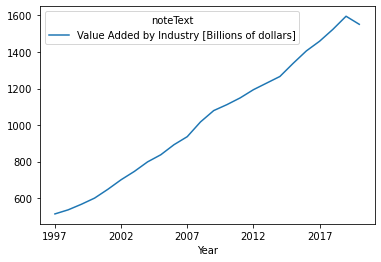

In [425]:
test['Health care and social assistance'].plot(kind='line')

<AxesSubplot:xlabel='Year'>

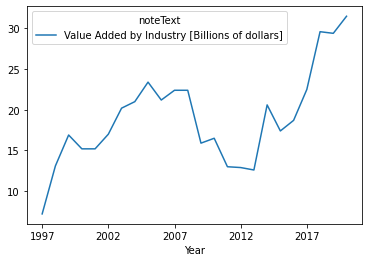

In [433]:
test['Funds, trusts, and other financial vehicles'].plot(kind='line')

<AxesSubplot:xlabel='Year'>

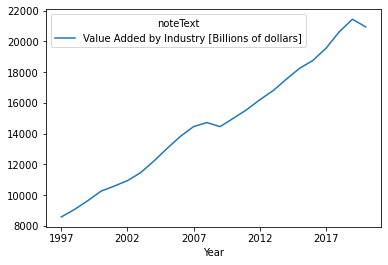

In [427]:
test['Gross domestic product'].plot(kind='line')

<AxesSubplot:xlabel='Year'>

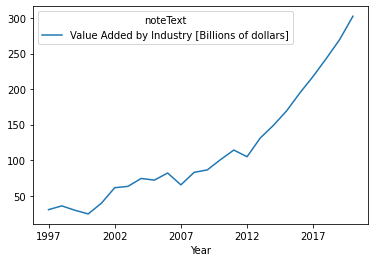

In [431]:
test['Data processing, internet publishing, and other information services'].plot(kind='line')

<AxesSubplot:xlabel='Year'>

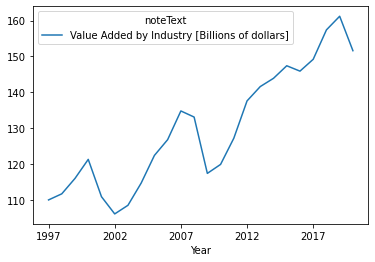

In [434]:
test['Fabricated metal products'].plot(kind='line')

<AxesSubplot:xlabel='Year'>

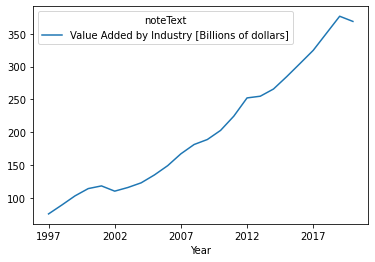

In [435]:
test['Computer systems design and related services'].plot(kind='line')

In [460]:
qtest = datasetsQ['1']

In [466]:
qtest.index.get_level_values(0)

Index(['Accommodation', 'Accommodation and food services',
       'Administrative and support services',
       'Administrative and waste management services',
       'Agriculture, forestry, fishing, and hunting', 'Air transportation',
       'Ambulatory health care services',
       'Amusements, gambling, and recreation industries',
       'Apparel and leather and allied products',
       'Arts, entertainment, and recreation',
       'Arts, entertainment, recreation, accommodation, and food services',
       'Broadcasting and telecommunications', 'Chemical products',
       'Computer and electronic products',
       'Computer systems design and related services', 'Construction',
       'Data processing, internet publishing, and other information services',
       'Durable goods', 'Educational services',
       'Educational services, health care, and social assistance',
       'Electrical equipment, appliances, and components',
       'Fabricated metal products', 'Farms', 'Federal',
  

<AxesSubplot:xlabel='Period'>

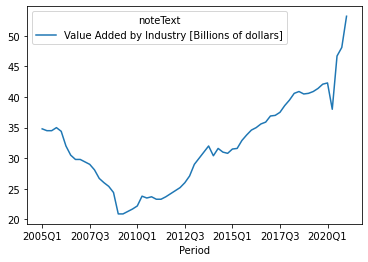

In [469]:
qtest.T['Wood products'].plot(kind='line')

In [470]:
import pandas_datareader as web

In [475]:
fdx = web.DataReader('FDX', 'yahoo', start='2005-01-01', end='2021-09-21')['Adj Close']

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/FDX/history?period1=1104548400&period2=1632275999&interval=1d&frequency=1d&filter=history
Response Text:
b'<!DOCTYPE html>\n  <html lang="en-us"><head>\n  <meta http-equiv="content-type" content="text/html; charset=UTF-8">\n      <meta charset="utf-8">\n      <title>Yahoo</title>\n      <meta name="viewport" content="width=device-width,initial-scale=1,minimal-ui">\n      <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n      <style>\n  html {\n      height: 100%;\n  }\n  body {\n      background: #fafafc url(https://s.yimg.com/nn/img/sad-panda-201402200631.png) 50% 50%;\n      background-size: cover;\n      height: 100%;\n      text-align: center;\n      font: 300 18px "helvetica neue", helvetica, verdana, tahoma, arial, sans-serif;\n  }\n  table {\n      height: 100%;\n      width: 100%;\n      table-layout: fixed;\n      border-collapse: collapse;\n      border-spacing: 0;\n      border: none;\n  }\n  h1 {\n      font-size: 42px;\n      font-weight: 400;\n      color: #400090;\n  }\n  p {\n      color: #1A1A1A;\n  }\n  #message-1 {\n      font-weight: bold;\n      margin: 0;\n  }\n  #message-2 {\n      display: inline-block;\n      *display: inline;\n      zoom: 1;\n      max-width: 17em;\n      _width: 17em;\n  }\n      </style>\n  <script>\n    document.write(\'<img src="//geo.yahoo.com/b?s=1197757129&t=\'+new Date().getTime()+\'&src=aws&err_url=\'+encodeURIComponent(document.URL)+\'&err=%<pssc>&test=\'+encodeURIComponent(\'%<{Bucket}cqh[:200]>\')+\'" width="0px" height="0px"/>\');var beacon = new Image();beacon.src="//bcn.fp.yahoo.com/p?s=1197757129&t="+new Date().getTime()+"&src=aws&err_url="+encodeURIComponent(document.URL)+"&err=%<pssc>&test="+encodeURIComponent(\'%<{Bucket}cqh[:200]>\');\n  </script>\n  </head>\n  <body>\n  <!-- status code : 404 -->\n  <!-- Not Found on Server -->\n  <table>\n  <tbody><tr>\n      <td>\n      <img src="https://s.yimg.com/rz/p/yahoo_frontpage_en-US_s_f_p_205x58_frontpage.png" alt="Yahoo Logo">\n      <h1 style="margin-top:20px;">Will be right back...</h1>\n      <p id="message-1">Thank you for your patience.</p>\n      <p id="message-2">Our engineers are working quickly to resolve the issue.</p>\n      </td>\n  </tr>\n  </tbody></table>\n  </body></html>'

In [501]:
fdx = pd.read_csv('fdx.csv')

In [504]:
fdx['Date'] = pd.to_datetime(fdx['Date'])
fdx = fdx.set_index(fdx['Date'])

In [530]:
tocorr = pd.concat([qtest.T['Truck transportation'],fdx.resample('Q').last()])

In [531]:
display(tocorr)

,Value Added by Industry [Billions of dollars],Date,Open,High,Low,Close,Adj Close,Volume
2005Q1,110.9,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2005Q2,114.8,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2005Q3,119.5,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2005Q4,122.5,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2006Q1,122.8,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-09-30 00:00:00,NaN,2020-09-30,253.470001,257.510010,249.500000,251.520004,248.983932,2506000.0
2020-12-31 00:00:00,NaN,2020-12-31,259.600006,260.459991,257.510010,259.619995,257.577789,2607800.0
2021-03-31 00:00:00,NaN,2021-03-31,286.000000,287.880005,282.829987,284.040009,282.539429,2026000.0
2021-06-30 00:00:00,NaN,2021-06-30,296.029999,298.619995,295.000000,298.329987,297.488617,1810900.0


In [524]:
tocorr['Trucking'] = qtest.T['Truck transportation'].values

Date
2005-03-31 00:00:00                                             83.01136
2005-06-30 00:00:00                                            71.641708
2005-09-30 00:00:00                                            77.129959
2005-12-31 00:00:00                                            91.598862
2006-03-31 00:00:00                                           100.131355
                                             ...                        
2020-12-31 00:00:00                                           257.577789
2021-03-31 00:00:00                                           282.539429
2021-06-30 00:00:00                                           297.488617
2021-09-30 00:00:00                                           252.070007
Trucking               [[110.9], [114.8], [119.5], [122.5], [122.8], ...
Name: Adj Close, Length: 68, dtype: object

<AxesSubplot:xlabel='Period'>

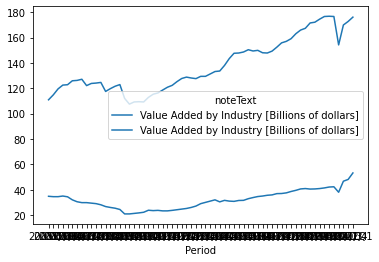

In [535]:
sns.lineplot(data=qtest.T['Wood products'])
sns.lineplot(data=qtest.T['Truck transportation'])

In [551]:
qtest = qtest.T

In [634]:
pc = qtest.pct_change()

array([[<AxesSubplot:title={'center':'Value Added by Industry [Billions of dollars]'}>]],
      dtype=object)

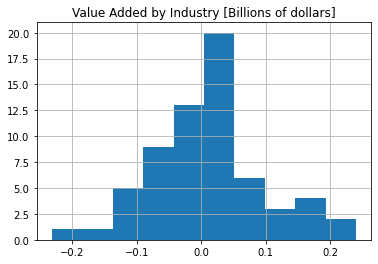

In [643]:
pc['Funds, trusts, and other financial vehicles'].hist(bins=10)

array([[<AxesSubplot:title={'center':'Value Added by Industry [Billions of dollars]'}>]],
      dtype=object)

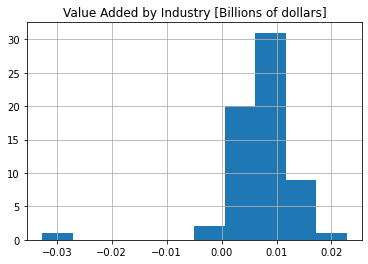

In [639]:
pc['Government'].hist(bins=10)

array([[<AxesSubplot:title={'center':'Value Added by Industry [Billions of dollars]'}>]],
      dtype=object)

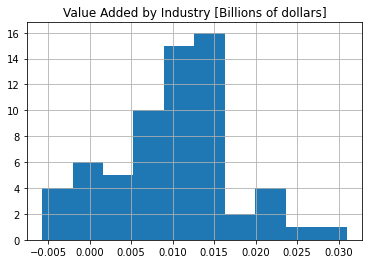

In [640]:
pc['Real estate'].hist(bins=10)

In [633]:
date = qtest.index

In [618]:
colnames = qtest.columns.get_level_values(0)

dflist = []
for x in colnames:
    val = [int(value) for value in qtest[x].values]
    dflist.append(val)

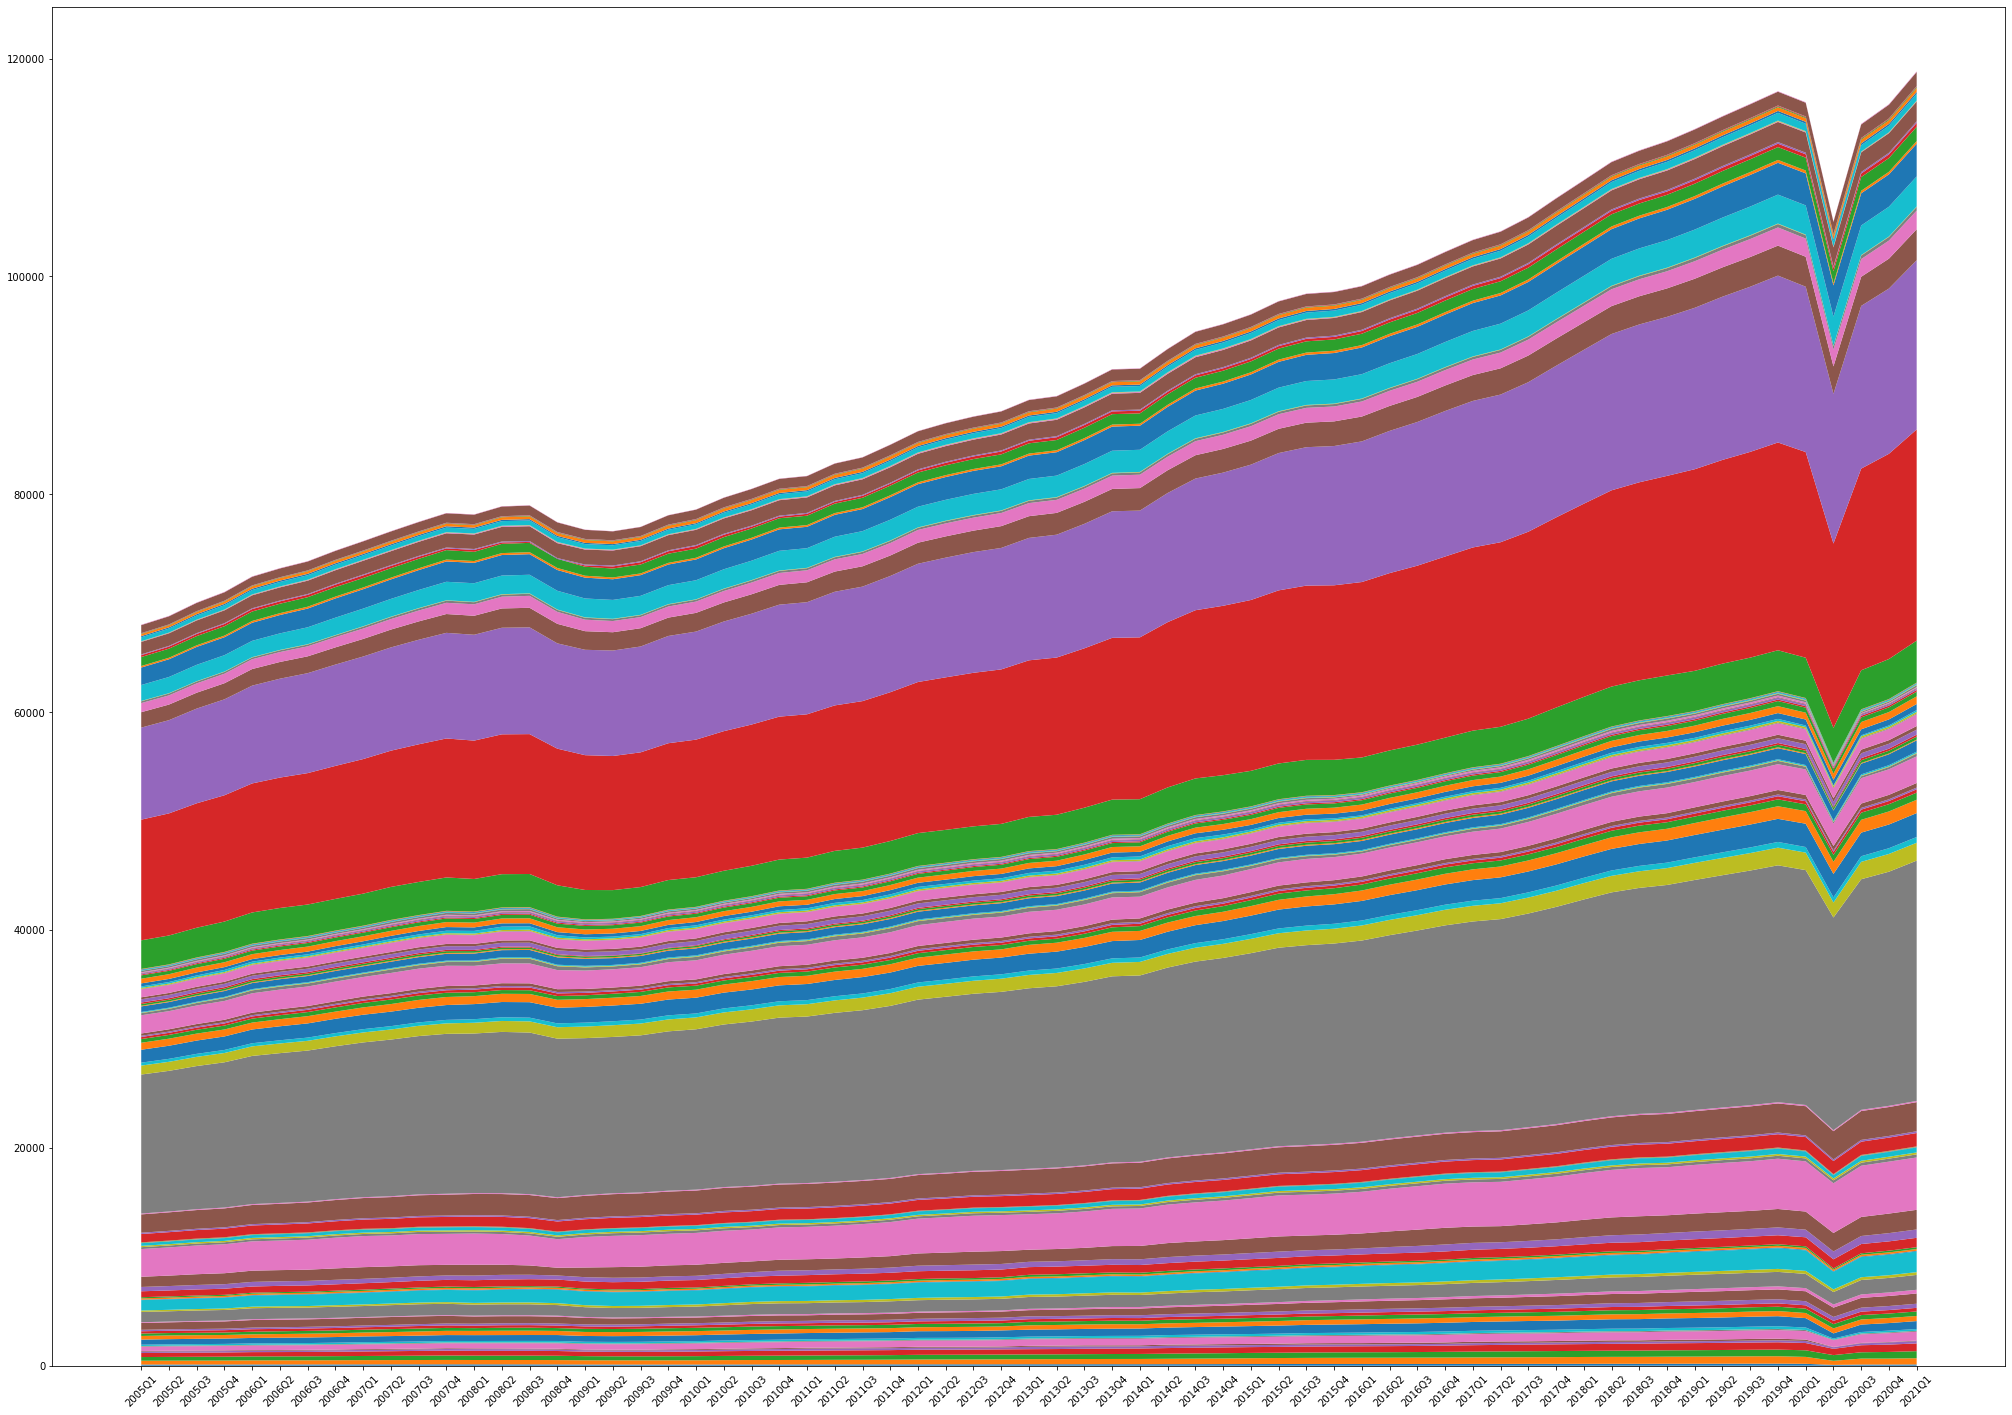

In [631]:
fig, ax = plt.subplots(figsize=(35, 25))
ax.stackplot(date, [i for i in dflist])
plt.xticks(rotation=45)
plt.show()

In [665]:
highest = dict(qtest.sum().sort_values(ascending=False))

In [ ]:
valslist = ['Accommodation and food services','Agriculture, forestry, fishing, and hunting','Air transportation',
           'Administrative and waste management services', 'Arts, entertainment, and recreation', 
            'Broadcasting and telecommunications', 'Computer and electronic products', 'Computer systems design and related services', 
            'Construction', 'Data processing, internet publishing, and other information services', 
            'Electrical equipment, appliances, and components', 'Fabricated metal products', 'Farms', 'Federal',
            'Federal Reserve banks, credit intermediation, and related activities',
            'Finance and insurance', 'Food and beverage stores', 'Food services and drinking places', 
            'Funds, trusts, and other financial vehicles', 'Government', 'Government enterprises',
            'Health care and social assistance', 'Hospitals', 'Housing', 'Information', 'Insurance carriers and related activities', 
            'Legal services', 'Machinery', 'Management of companies and enterprises', 'Manufacturing', 
            'Mining', 'Mining, except oil and gas', 'Motion picture and sound recording industries',
            'Motor vehicles, bodies and trailers, and parts', 'National defense', 'Nondefense', 
            'Oil and gas extraction', 'Petroleum and coal products', 'Pipeline transportation',
            'Primary metals', 'Rail transportation', 'Real estate', 'Rental and leasing services and lessors of intangible assets',
            'Securities, commodity contracts, and investments', 'Transit and ground passenger transportation',
            'Utilities', 'Water transportation', 'Wholesale trade', 'Wood products', 'Warehousing and storage'
           ]

In [654]:
shortlist = []
for x in valslist:
    val = [int(value) for value in qtest[x].values]
    shortlist.append(val)

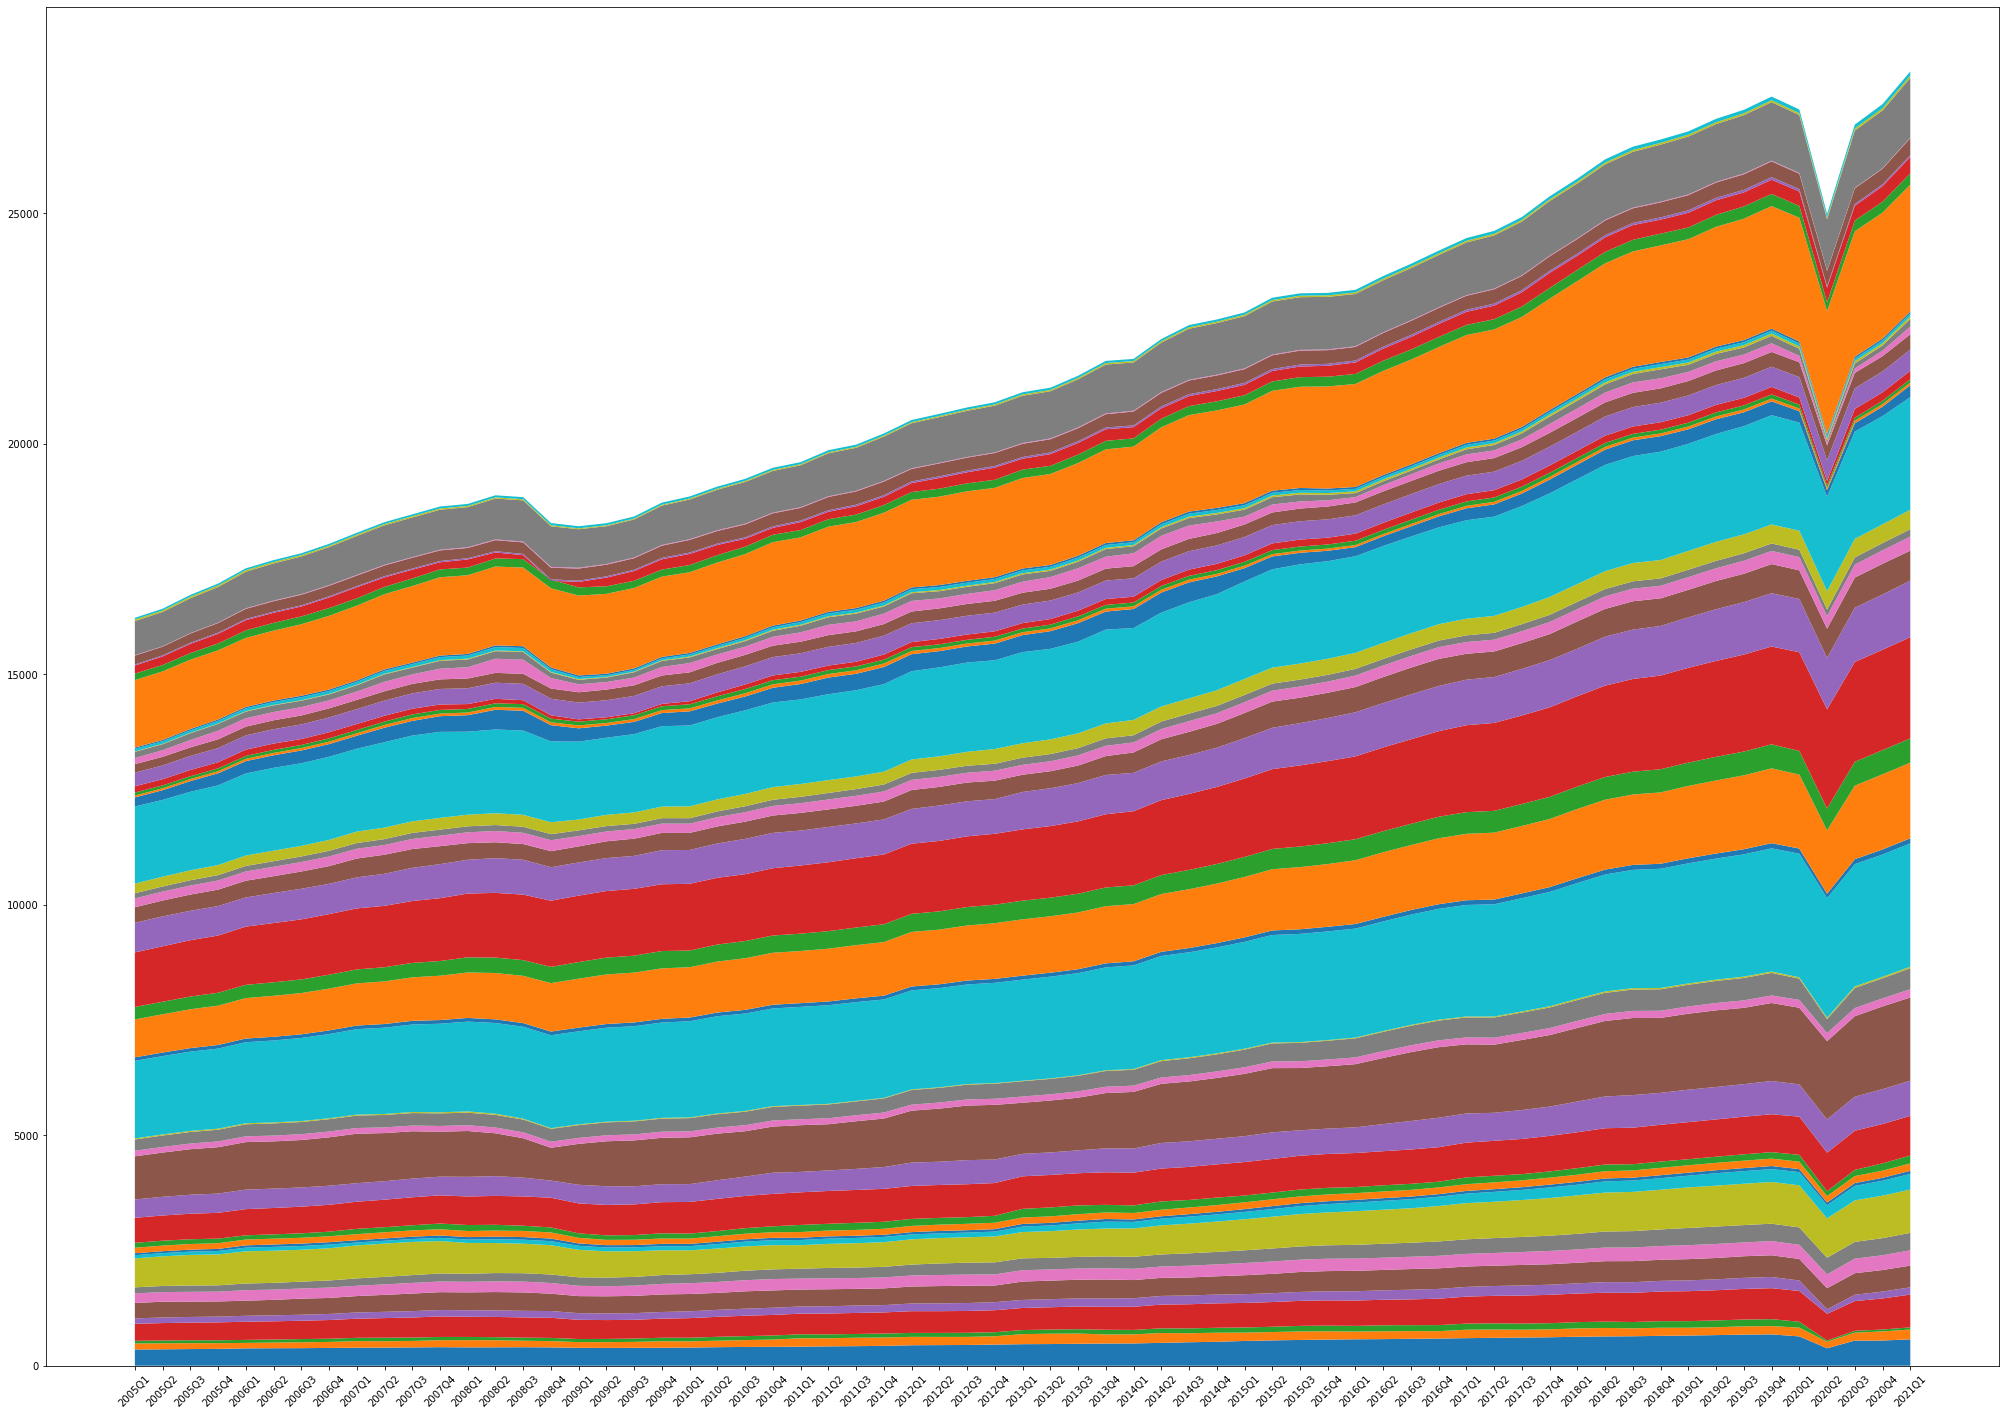

In [655]:
fig, ax = plt.subplots(figsize=(35, 25))
ax.stackplot(date, [i for i in shortlist])
plt.xticks(rotation=45)
plt.show()

In [666]:
highest

{('Gross domestic product',
  'Value Added by Industry [Billions of dollars]'): 1106128.2,
 ('Private industries',
  'Value Added by Industry [Billions of dollars]'): 962204.1,
 ('Private services-producing industries<sup>2</sup>',
  'Value Added by Industry [Billions of dollars],2. Consists of utilities; wholesale trade; retail trade; transportation and warehousing; information; finance, insurance, real estate, rental, and leasing; professional and business services; educational services, health care, and social assistance; arts, entertainment, recreation, accommodation, and food services; and other services, except government.'): 756992.2999999999,
 ('Finance, insurance, real estate, rental, and leasing',
  'Value Added by Industry [Billions of dollars]'): 226144.99999999997,
 ('Private goods-producing industries<sup>1</sup>',
  'Value Added by Industry [Billions of dollars],1. Consists of agriculture, forestry, fishing, and hunting; mining; construction; and manufacturing.'): 205210

In [678]:
forcsv = ['Accommodation and food services','Air transportation','Arts, entertainment, and recreation', 
            'Broadcasting and telecommunications', 'Computer and electronic products', 'Computer systems design and related services', 
            'Construction', 'Data processing, internet publishing, and other information services', 
            'Fabricated metal products', 'Farms', 'Federal',
            'Federal Reserve banks, credit intermediation, and related activities',
            'Finance and insurance', 'Food and beverage stores', 'Food services and drinking places', 
            'Funds, trusts, and other financial vehicles', 'Government', 'Government enterprises',
            'Health care and social assistance', 'Hospitals', 'Housing', 'Information', 'Insurance carriers and related activities', 
            'Legal services', 'Machinery', 'Management of companies and enterprises', 'Manufacturing', 
            'Mining, except oil and gas', 'Motion picture and sound recording industries',
            'Motor vehicles, bodies and trailers, and parts', 'National defense', 'Nondefense', 
            'Oil and gas extraction', 'Petroleum and coal products', 'Pipeline transportation',
            'Primary metals', 'Rail transportation', 'Real estate', 'Rental and leasing services and lessors of intangible assets',
            'Securities, commodity contracts, and investments', 'Transit and ground passenger transportation',
            'Utilities', 'Water transportation', 'Wholesale trade', 'Wood products', 'Warehousing and storage'
           ]

In [681]:
tocsv = pd.DataFrame(qtest[forcsv])

Period,2005Q1,2005Q2,2005Q3,2005Q4,2006Q1,2006Q2,2006Q3,2006Q4,2007Q1,2007Q2,...,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1
IndustrYDescription,,,,,,,,,,,,,,,,,,,,,
Accommodation and food services,352.80,356.4,361.40,365.4,376.50,379.30,381.60,386.90,391.60,393.30,...,648.5,654.80,664.0,675.6,680.0,636.00,378.1,545.9,546.0,573.50
Air transportation,58.50,61.5,63.30,63.6,65.80,66.40,70.30,69.60,71.20,77.50,...,142.1,143.00,146.2,149.0,150.0,127.20,27.1,40.5,41.4,47.30
"Arts, entertainment, and recreation",118.90,121.1,123.80,125.1,128.80,130.50,130.00,132.60,135.40,136.30,...,231.9,234.30,236.3,240.4,243.5,227.30,98.2,137.1,150.2,157.80
Broadcasting and telecommunications,333.20,343.1,332.70,329.7,328.40,336.60,349.00,347.10,356.60,368.20,...,457.4,461.10,463.8,469.7,471.9,468.70,458.2,468.2,467.9,472.00
Computer and electronic products,209.70,208.1,213.60,213.7,228.10,222.00,220.90,225.40,223.20,227.00,...,299.5,303.30,304.6,299.5,308.3,306.80,300.5,315.2,320.9,332.90
Computer systems design and related services,131.30,133.6,137.00,137.7,145.40,146.50,149.80,154.10,160.40,164.30,...,360.0,374.30,378.1,377.3,377.4,378.10,361.2,365.2,371.1,378.00
Construction,628.50,643.7,664.20,670.8,698.80,698.50,691.60,699.50,715.10,722.00,...,860.5,880.10,887.4,897.7,905.5,914.60,853.7,899.5,922.5,940.40
"Data processing, internet publishing, and other information services",70.70,70.1,71.90,75.0,80.80,83.90,82.50,80.60,64.10,61.90,...,252.3,254.50,270.1,273.7,280.9,285.50,285.3,315.5,324.2,340.50
Fabricated metal products,120.70,121.8,122.70,124.2,126.30,126.20,126.20,128.50,132.20,134.70,...,159.3,161.00,160.6,161.5,161.7,161.00,138.9,151.5,155.1,160.50


In [682]:
tocsv = tocsv.T.droplevel(1)

In [688]:
tocsv.isna().sum()

Period
2005Q1    0
2005Q2    0
2005Q3    0
2005Q4    0
2006Q1    0
         ..
2020Q1    0
2020Q2    0
2020Q3    0
2020Q4    0
2021Q1    0
Length: 65, dtype: int64

In [684]:
tocsv.T.to_csv('streamgraph.csv')

In [676]:
highest[('Gross domestic product','Value Added by Industry [Billions of dollars]')]

1106128.2

In [ ]:
dedrotest 

In [677]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = hierarchy.linkage(ytdist, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)